# 2022 Comparative analysis benchmark

Logbook: https://docs.google.com/document/d/1NsqY_mA7U-jY2aLQlaQimiNLaRvYVx26cAia8HTdG_M/edit#


In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.display import display
import pandas as pd

import seaborn as sns

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import scipy as sp
import os, re
import glob
from tqdm.auto import tqdm
import tempfile
from itertools import product


In [2]:
# Ignore H3K27ac, H3K27ac because of a single replicate, bad quality
MODIFICATIONS = [
    'H3K4me2', 'H3K4me3', 'H3K9ac', # narrow
    'H3K4me1', 'H3K9me3', 'H3K27me3', 'H3K36me3', 'H3K79me2', # broad
    'H3K4ac', 'H3K56ac', 'H3K79me1' # mixed
]
# MODIFICATIONS = ['H3K4me1', 'H3K4me3', 'H3K36me3']

PATH = os.path.expanduser('~/data/2022_comparative_analysis')
FIGURES_DIR = os.path.join(PATH, 'pics')
EXT = 'pdf'
! mkdir -p {FIGURES_DIR}

In [3]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0

## MACS2

In [4]:
MACS2_FOLDER = f'{PATH}/macs2'
MACS2_LEVELS = ['q0.05', 'broad0.1']

dfm = pd.DataFrame(columns=['modification', 'replicate', 'level', 'file', 'peaks'], dtype=object)
for file in tqdm(glob.glob(MACS2_FOLDER + '/*.*Peak')):
    if 'gapped' in file:
        continue
    level = next((l for l in MACS2_LEVELS if f'_{l}' in file), None)
    modification = next((m for m in MODIFICATIONS if f'_{m}' in file), None)
    if level and modification:
        replicate = os.path.basename(file).replace(f'H1_{modification}_', '')[:3]
        peaks = lines(file)
        dfm.loc[len(dfm)] = (modification, replicate, f'macs2 {level}', file, peaks)

  0%|          | 0/207 [00:00<?, ?it/s]

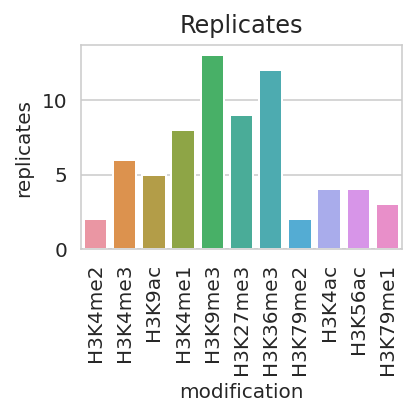

In [5]:
t = (dfm.groupby(['modification'])['file'].count() / len(MACS2_LEVELS)).astype(int)
plt.figure(figsize=(3, 3))
sns.barplot(data=pd.DataFrame(dict(modification=t.index, replicates=t)), x='modification', y='replicates',
            order=MODIFICATIONS)
plt.xticks(rotation=90)
plt.title('Replicates')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'replicates_macs2.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

In [6]:
macs2levels2process = {'macs2 q0.05', 'macs2 broad0.1'}

## SICER

In [7]:
SICER_FOLDER = f'{PATH}/sicer'
SICER_LEVELS = ['FDR0.01']

dfsc = pd.DataFrame(columns=['modification', 'replicate', 'level', 'file', 'peaks'], dtype=object)
for file in tqdm(glob.glob(SICER_FOLDER + '/*islands-summary*')):
    level = next((l for l in SICER_LEVELS if f'-{l}' in file), None)
    modification = next((m for m in MODIFICATIONS if f'_{m}' in file), None)
    if level and modification:
        replicate = os.path.basename(file).replace(f'H1_{modification}_', '')[:3]
        peaks = lines(file)
        dfsc.loc[len(dfsc)] = (modification, replicate, f'sicer {level}', file, peaks)

  0%|          | 0/70 [00:00<?, ?it/s]

In [8]:
sicerlevels2process = {'sicer FDR0.01'}

## SPAN

In [9]:
SPAN_FOLDER = f'{PATH}/span'
GAPS = [0]
FDRS = ['0.05']
SPAN_LEVELS = list(f'100_{fdr}_{gap}' for fdr, gap in product(FDRS, GAPS))

dfs = pd.DataFrame(columns=['modification', 'replicate', 'level', 'file', 'peaks'], dtype=object)
for file in tqdm(glob.glob(SPAN_FOLDER + '/*.peak')):
    if 'Input' in file:
        continue
    level = next((l for l in SPAN_LEVELS if f'_{l}' in file), None)
    modification = next((m for m in MODIFICATIONS if f'_{m}' in file), None)
    if level and modification:
        replicate = os.path.basename(file).replace(f'H1_{modification}_', '')[:3]
        peaks = lines(file)
        dfs.loc[len(dfs)] = (modification, replicate, f'span {level}', file, peaks)

  0%|          | 0/70 [00:00<?, ?it/s]

In [10]:
import re

dfs['fdr'] = [float(re.sub('span 100_|_(0|3|5|10)', '', l)) for l in dfs['level']]
dfs['gap'] = [int(re.sub('.*_', '', l)) for l in dfs['level']]
dfs.sort_values(by=['fdr', 'gap'], inplace=True)
dfs.head()

,modification,replicate,level,file,peaks,fdr,gap
0,H3K9ac,1_1,span 100_0.05_0,/home/jetbrains/data/2022_comparative_analysis...,14027,0.05,0
1,H3K9me3,4_4,span 100_0.05_0,/home/jetbrains/data/2022_comparative_analysis...,48240,0.05,0
2,H3K36me3,2_1,span 100_0.05_0,/home/jetbrains/data/2022_comparative_analysis...,12888,0.05,0
3,H3K36me3,4_1,span 100_0.05_0,/home/jetbrains/data/2022_comparative_analysis...,30616,0.05,0
4,H3K27me3,2_1,span 100_0.05_0,/home/jetbrains/data/2022_comparative_analysis...,4694,0.05,0


In [11]:
spanlevels2process = {'span 100_0.05_0'}

## Summary

In [12]:
dfa = pd.concat([
    dfm.loc[[l in macs2levels2process for l in dfm['level']]],
    dfs.loc[[l in spanlevels2process for l in dfs['level']]],
    dfsc.loc[[l in sicerlevels2process for l in dfsc['level']]],
])

In [13]:
dfa = dfa[~((dfa['modification'] == 'H3K9ac') & (dfa['replicate'] == '3_1') |
            (dfa['modification'] == 'H3K9me3') & (dfa['replicate'] == '5_1') |
            (dfa['modification'] == 'H3K36me3') & (dfa['replicate'] == '3_1') |
            (dfa['modification'] == 'H3K4me1') & (dfa['replicate'] == '3_1'))]

In [14]:
dfa.sample(5)

,modification,replicate,level,file,peaks,fdr,gap
27,H3K36me3,5_3,span 100_0.05_0,/home/jetbrains/data/2022_comparative_analysis...,30002,0.05,0.0
115,H3K9ac,4_1,macs2 q0.05,/home/jetbrains/data/2022_comparative_analysis...,9488,NaN,NaN
72,H3K4me1,6_1,macs2 broad0.1,/home/jetbrains/data/2022_comparative_analysis...,40053,NaN,NaN
54,H3K56ac,1_1,macs2 broad0.1,/home/jetbrains/data/2022_comparative_analysis...,16160,NaN,NaN
2,H3K9me3,1_1,macs2 q0.05,/home/jetbrains/data/2022_comparative_analysis...,17425,NaN,NaN


# Group analysis

In [15]:
def plot_data_cells(df, cid, value, description, bar=True, lower=None, upper=None, figx=None, figy=None):
    cids = list(set(df[cid]))
    axs = {}
    total = len(cids) * len(MODIFICATIONS)
    plt.figure(figsize=(figx or int(total / 3), figy or 4))
    offset = 0
    for m in MODIFICATIONS:
        data = df.loc[df['modification'] == m].sort_values(by=[cid])
        w = len(cids)
        ax = plt.subplot2grid((1, total), (0, offset), colspan=w)

        if bar:
            sns.barplot(data=data,
                        x=cid, y=value,
                        capsize=.2, errwidth=2,
                        ax=ax,
                        order=['macs2 q0.05', 'macs2 broad0.1', 'span 100_0.05_0', 'sicer FDR0.01'])

            sns.swarmplot(data=data,
                          x=cid, y=value,
                          size=1,
                          color="black",
                          alpha=0.8,
                          ax=ax,
                          order=['macs2 q0.05', 'macs2 broad0.1', 'span 100_0.05_0', 'sicer FDR0.01'])
        else:
            sns.boxplot(data=data, x=cid, y=value, showfliers=False, ax=ax,
                        order=['macs2 q0.05', 'macs2 broad0.1', 'span 100_0.05_0', 'sicer FDR0.01'])

            # ax.legend().remove()
        axs[ax] = plt.ylim()
        if offset > 0:
            ax.get_yaxis().set_ticklabels([])
            ax.set_ylabel('')
        else:
            ax.set_ylabel(description)

        offset += w
        ax.set_xlabel('')
        ax.set_title(m)
        ax.xaxis.set_tick_params(rotation=90)

    ymin = np.min([v[0] for v in axs.values()])
    if lower is not None:
        ymin = max(ymin, lower)
    ymax = np.max([v[1] for v in axs.values()])
    if upper is not None:
        ymax = min(ymax, upper)

    for ax in axs.keys():
        ax.set_ylim(bottom=ymin, top=ymax)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'{value}.{EXT}'), bbox_inches='tight', dpi=300)
    plt.show()


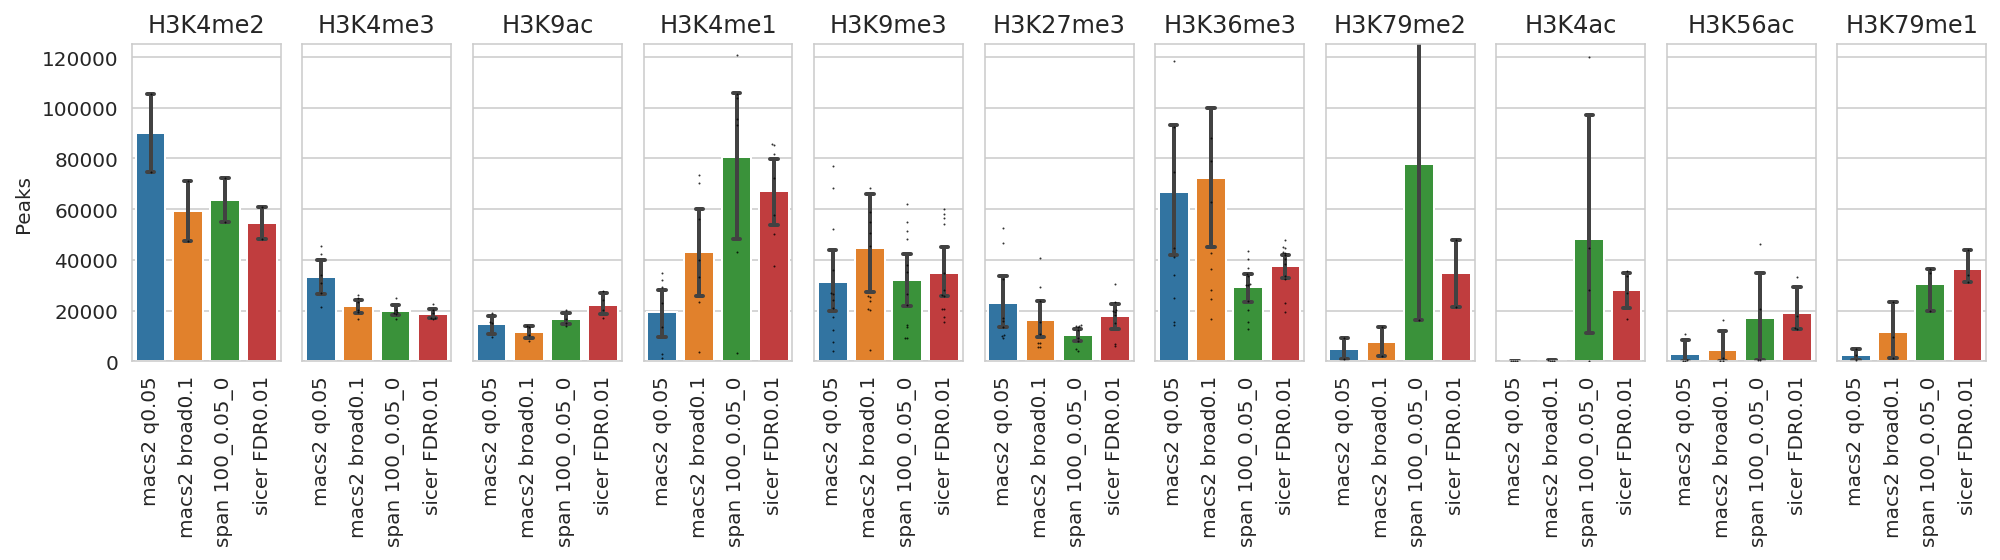

In [16]:
plot_data_cells(dfa, 'level', 'peaks', 'Peaks', upper=125_000, figx=14, figy=4)

In [17]:
ts = []
for modification, level, file in tqdm(zip(dfa['modification'], dfa['level'], dfa['file'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t['modification'] = modification
    t['level'] = level
    ts.append(t.sample(min(len(t), 10_000)))
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

0it [00:00, ?it/s]

,length,modification,level
1918908,3799,H3K4me1,sicer FDR0.01
635817,255,H3K36me3,macs2 broad0.1
24482,367,H3K79me2,macs2 broad0.1
2206231,4199,H3K36me3,sicer FDR0.01
1281024,2195,H3K4me3,span 100_0.05_0
2031746,4399,H3K4me1,sicer FDR0.01
1984559,799,H3K9ac,sicer FDR0.01
258439,1090,H3K27me3,macs2 broad0.1
685425,1373,H3K9ac,macs2 q0.05
616971,507,H3K27me3,macs2 broad0.1


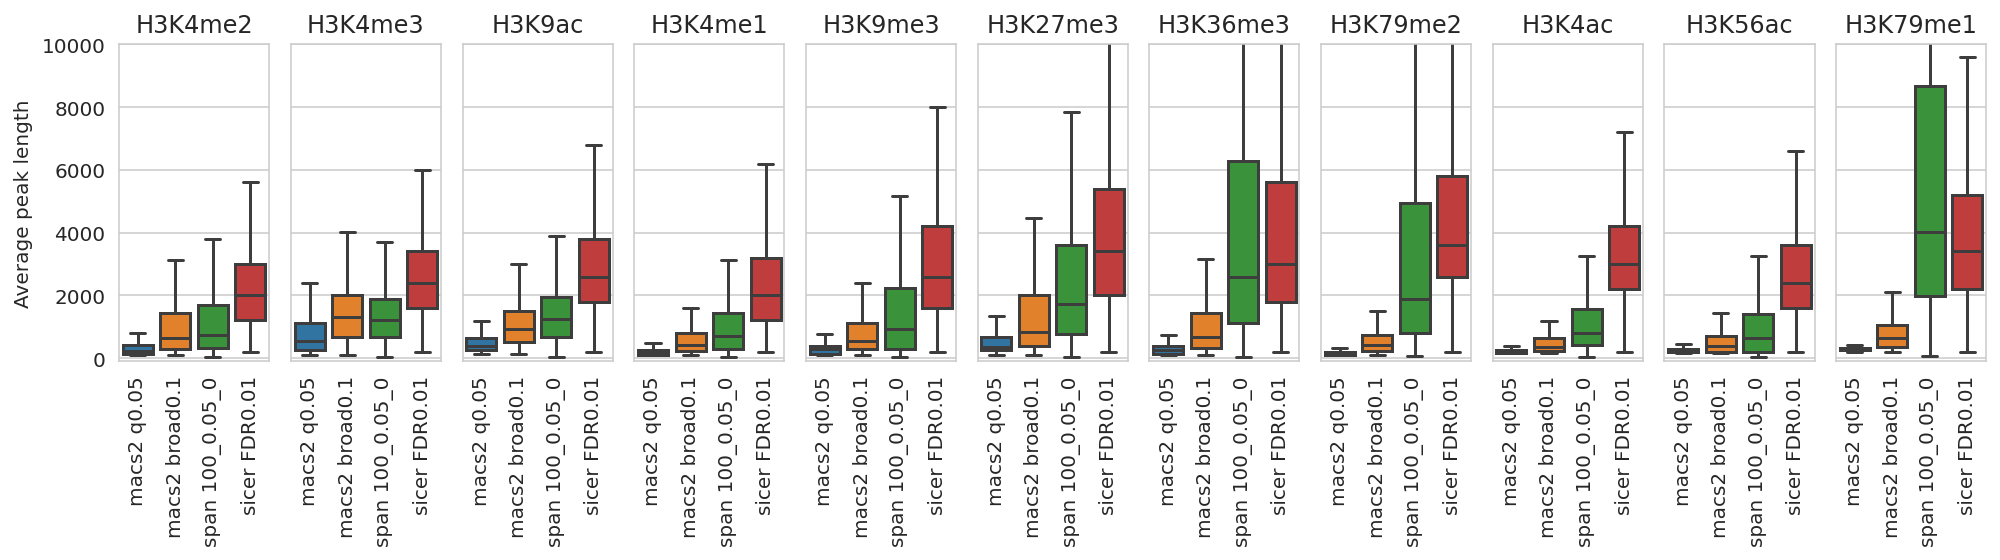

In [18]:
plot_data_cells(t, 'level', 'length', 'Average peak length', bar=False, lower=-100, upper=10_000, figx=14, figy=4)

# Consistency analysis between replicates

In [19]:
import tempfile

reps_overlap = pd.DataFrame(columns=['modification', 'tool', 'rep1', 'rep2',
                                     'peaks1', 'peaks2', 'length1', 'length2',
                                     'overlap', 'overlap1', 'overlap2', 'intersect_length'], dtype=object)

for m in tqdm(MODIFICATIONS):
    print(m)
    tm = dfa[dfa['modification'] == m]
    for tool in list(sorted(set(tm['level']))):
        reps = list(sorted(tm[tm['level'] == tool]['replicate'].unique()))
        for i in range(len(reps)):
            for j in range(i + 1, len(reps)):
                rep1, rep2 = reps[i], reps[j]
                t1 = tm[(tm['level'] == tool) & (tm['replicate'] == rep1)]
                t2 = tm[(tm['level'] == tool) & (tm['replicate'] == rep2)]
                # print(m, tool, rep1, rep2, len(t1), len(t2))
                file1 = t1['file'].values[0]
                peaks1, length1 = t1['peaks'].values[0], bedl(file1).sum()
                file2 = t2['file'].values[0]
                peaks2, length2 = t2['peaks'].values[0], bedl(file2).sum()
                for overlap, overlap_param in [
                    ('1bp overlap', ''),
                    ('50% overlap', ' -f 0.5 '),
                ]:
                    overlap1 = !bedtools intersect -a {file1} -b {file2} -wa -u {overlap_param} | wc -l
                    overlap1 = int(overlap1[0])
                    overlap2 = !bedtools intersect -b {file1} -a {file2} -wa -u {overlap_param} | wc -l
                    overlap2 = int(overlap2[0])
                    tf = tempfile.mktemp()
                    !bedtools intersect -a {file1} -b {file2} > {tf}
                    intersection_length = bedl(tf).sum()
                    reps_overlap.loc[len(reps_overlap)] = \
                        (m, tool, rep1, rep2, peaks1, peaks2, length1, length2,
                         overlap, overlap1, overlap2, intersection_length)

  0%|          | 0/11 [00:00<?, ?it/s]

H3K4me2
H3K4me3
H3K9ac
H3K4me1
H3K9me3
H3K27me3
H3K36me3
H3K79me2
H3K4ac
H3K56ac
H3K79me1


In [20]:
ro = pd.DataFrame(columns=['Modification', 'Replicate', 'Tool', 'OverlapType', 'Overlap'], dtype=object)
for _, row in reps_overlap.iterrows():
    m = row['modification']
    tool = row['tool']
    rep1 = row['rep1']
    rep2 = row['rep2']
    peaks1 = row['peaks1']
    peaks2 = row['peaks2']
    overlap = row['overlap']
    overlap1 = row['overlap1']
    overlap2 = row['overlap2']
    ro.loc[len(ro)] = (m, f'{rep1} vs {rep2}', tool, overlap, d(overlap1, peaks1))
    ro.loc[len(ro)] = (m, f'{rep2} vs {rep1}', tool, overlap, d(overlap2, peaks2))
ro.sample(5)

,Modification,Replicate,Tool,OverlapType,Overlap
220,H3K4me3,2_1 vs 5_2,span 100_0.05_0,1bp overlap,0.968233
1203,H3K9me3,4_5 vs 4_2,macs2 q0.05,50% overlap,0.648717
1378,H3K9me3,2_1 vs 4_1,sicer FDR0.01,50% overlap,0.153629
939,H3K9me3,4_5 vs 4_2,macs2 broad0.1,50% overlap,0.733044
768,H3K9me3,1_2 vs 4_5,macs2 broad0.1,1bp overlap,0.368019


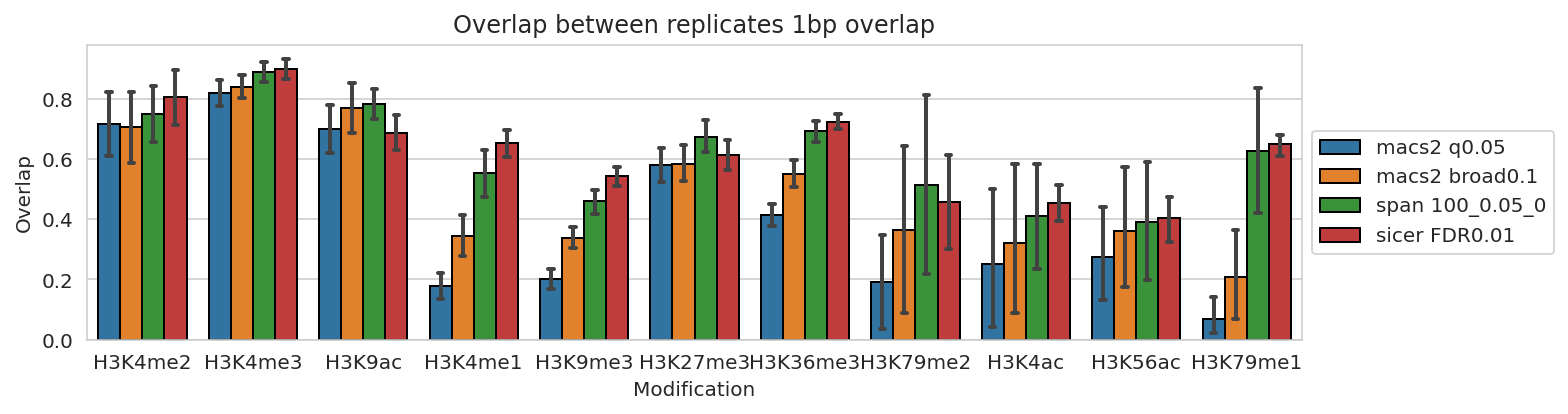

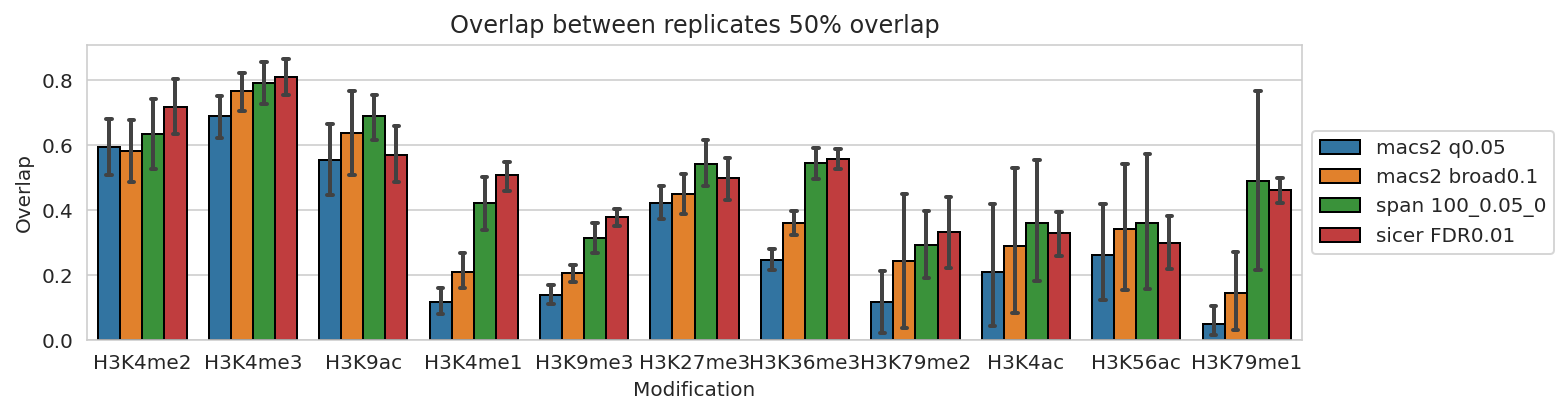

In [32]:
for overlap in ro['OverlapType'].unique():
    plt.figure(figsize=(11, 3))
    plt.title(f'Overlap between replicates {overlap}')
    g_results = sns.barplot(data=ro[ro['OverlapType'] == overlap], x='Modification', y='Overlap', hue='Tool',
                            capsize=.05, errwidth=2, edgecolor="black",
                            order=MODIFICATIONS,
                            hue_order=['macs2 q0.05', 'macs2 broad0.1', 'span 100_0.05_0', 'sicer FDR0.01'])
    # sns.boxplot(data=ro, x='Modification', y='Overlap', hue='Tool')
    # Put a legend to the right of the current axis
    g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'overlap.{EXT}'), bbox_inches='tight', dpi=300)
    plt.show()

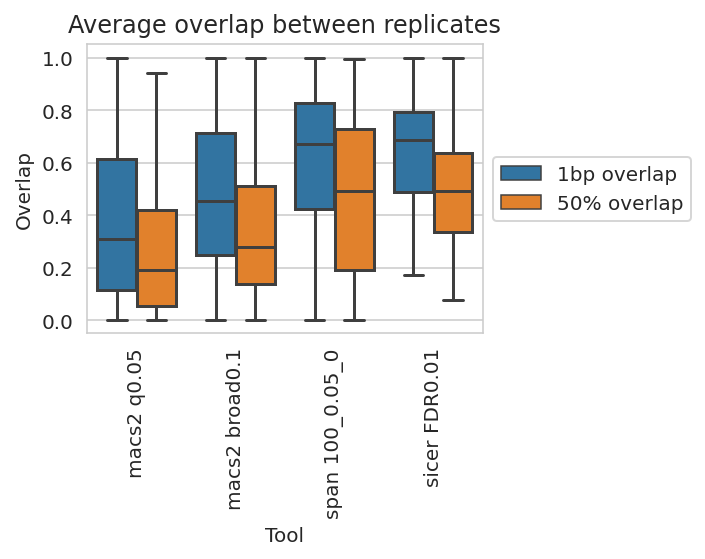

In [33]:
plt.figure(figsize=(5, 4))
plt.title(f'Average overlap between replicates')
g_results = sns.boxplot(data=ro, x='Tool', y='Overlap', hue='OverlapType', showfliers=False,
                       order=['macs2 q0.05', 'macs2 broad0.1', 'span 100_0.05_0', 'sicer FDR0.01'])
g_results.axes.xaxis.set_tick_params(rotation=90)
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'overlap.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

In [23]:
rj = pd.DataFrame(columns=['Modification', 'Replicate', 'Tool', 'Jaccard'], dtype=object)
for _, row in reps_overlap[reps_overlap['overlap'] == '1bp overlap'].iterrows():
    m = row['modification']
    tool = row['tool']
    rep1 = row['rep1']
    rep2 = row['rep2']
    length1 = row['length1']
    length2 = row['length2']
    intersection = row['intersect_length']
    try:
        jaccard = intersection / (length1 + length2 - intersection)
    except:
        jaccard = 0
    rj.loc[len(rj)] = (m, f'{rep1} vs {rep2}', tool, jaccard)
rj.sample(5)

,Modification,Replicate,Tool,Jaccard
680,H3K36me3,5_3 vs 5_4,macs2 q0.05,0.320026
573,H3K27me3,4_1 vs 7_1,span 100_0.05_0,0.565366
422,H3K9me3,3_2 vs 4_2,span 100_0.05_0,0.042246
183,H3K9me3,1_2 vs 1_3,macs2 broad0.1,0.307906
639,H3K36me3,1_1 vs 5_2,macs2 q0.05,0.104481


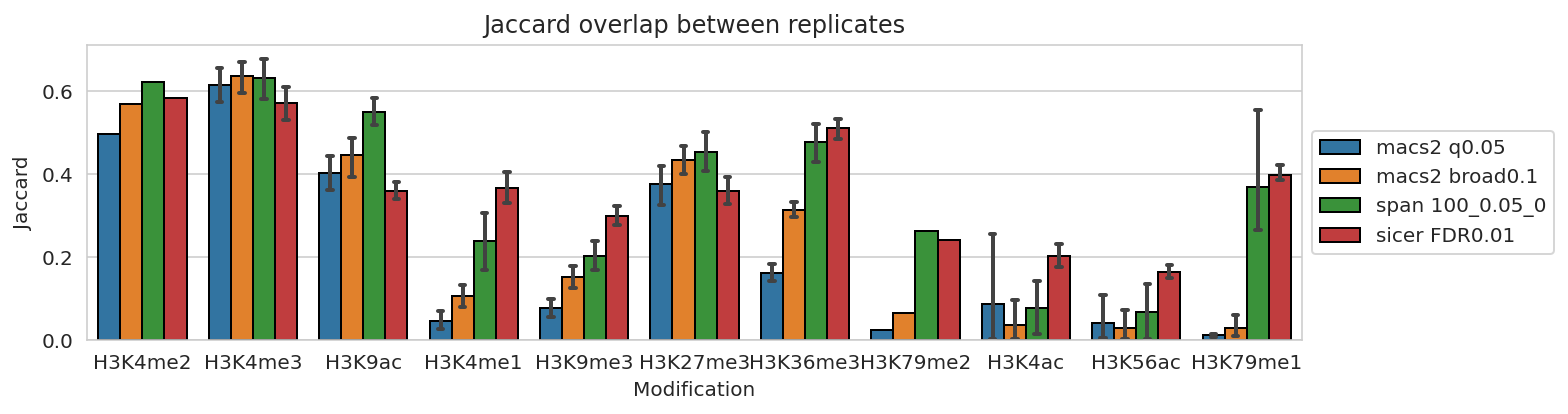

In [34]:
plt.figure(figsize=(11, 3))
plt.title('Jaccard overlap between replicates')
g_results = sns.barplot(data=rj, x='Modification', y='Jaccard', hue='Tool', capsize=.05, errwidth=2, edgecolor="black",
                        order=MODIFICATIONS,
                        hue_order=['macs2 q0.05', 'macs2 broad0.1', 'span 100_0.05_0', 'sicer FDR0.01'])
# sns.boxplot(data=rj, x='Modification', y='Jaccard', hue='Tool')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

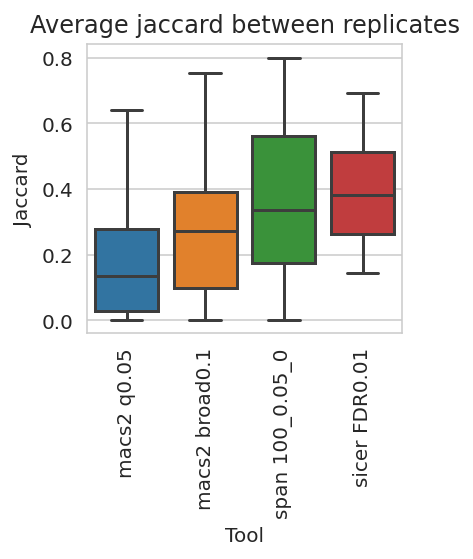

In [25]:
plt.figure(figsize=(3, 4))
plt.title(f'Average jaccard between replicates')
g_result = sns.boxplot(data=rj, x='Tool', y='Jaccard', showfliers=False,
                       order=['macs2 q0.05', 'macs2 broad0.1', 'span 100_0.05_0', 'sicer FDR0.01'])
g_result.axes.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'overlap.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

# Consistency analysis between different tools

In [26]:
import tempfile

tools_overlap = pd.DataFrame(columns=['modification', 'rep', 'tool1', 'tool2',
                                      'peaks1', 'peaks2', 'length1', 'length2',
                                       'overlap1', 'overlap2', 'intersect'], dtype=object)

tools = list(sorted(set(dfa['level'])))
for m in tqdm(MODIFICATIONS):
    print(m)
    tm = dfa.loc[dfa['modification'] == m]
    reps = list(sorted(set(tm['replicate'])))
    for rep in reps:
        for i in range(len(tools)):
            for j in range(i + 1, len(tools)):
                tool1, tool2 = tools[i], tools[j]
                t1 = tm.loc[(tm['level'] == tool1) & (tm['replicate'] == rep)]
                t2 = tm.loc[(tm['level'] == tool2) & (tm['replicate'] == rep)]
                if len(t1) == 0 or len(t2) == 0:
                    continue
                m = t1['modification'].values[0]
                file1 = t1['file'].values[0]
                peaks1 = t1['peaks'].values[0]
                length1 = bedl(file1).sum()
                file2 = t2['file'].values[0]
                peaks2 = t2['peaks'].values[0]
                length2 = bedl(file2).sum()
                overlap1 = !bedtools intersect -a {file1} -b {file2} -wa -u | wc -l
                overlap1 = int(overlap1[0])
                overlap2 = !bedtools intersect -b {file1} -a {file2} -wa -u | wc -l
                overlap2 = int(overlap2[0])
                tf = tempfile.mktemp()
                !bedtools intersect -b {file1} -a {file2} > {tf}
                intersection_length = bedl(tf).sum()
                tools_overlap.loc[len(tools_overlap)] = \
                    (m, rep, tool1, tool2, peaks1, peaks2, length1, length2,
                     overlap1, overlap2, intersection_length)

  0%|          | 0/11 [00:00<?, ?it/s]

H3K4me2
H3K4me3
H3K9ac
H3K4me1
H3K9me3
H3K27me3
H3K36me3
H3K79me2
H3K4ac
H3K56ac
H3K79me1


## Overlap between tools

In [27]:
to = pd.DataFrame(columns=['modification', 'replicate', 'tool1', 'tool2', 'overlap'], dtype=object)
for _, row in tools_overlap.iterrows():
    m = row['modification']
    rep = row['rep']
    tool1 = row['tool1']
    tool2 = row['tool2']
    peaks1 = row['peaks1']
    peaks2 = row['peaks2']
    overlap1 = row['overlap1']
    overlap2 = row['overlap2']
    to.loc[len(to)] = (m, rep, tool1, tool2, overlap1 / peaks1 if peaks1 != 0 else 0)
    to.loc[len(to)] = (m, rep, tool2, tool1, overlap2 / peaks2 if peaks2 != 0 else 0)
to

,modification,replicate,tool1,tool2,overlap
0,H3K4me2,1_2,macs2 broad0.1,macs2 q0.05,0.660395
1,H3K4me2,1_2,macs2 q0.05,macs2 broad0.1,1.000000
2,H3K4me2,1_2,macs2 broad0.1,sicer FDR0.01,0.954904
3,H3K4me2,1_2,sicer FDR0.01,macs2 broad0.1,0.785376
4,H3K4me2,1_2,macs2 broad0.1,span 100_0.05_0,0.967631
...,...,...,...,...,...
765,H3K79me1,3_1,sicer FDR0.01,macs2 q0.05,0.010478
766,H3K79me1,3_1,macs2 q0.05,span 100_0.05_0,1.000000
767,H3K79me1,3_1,span 100_0.05_0,macs2 q0.05,0.009128
768,H3K79me1,3_1,sicer FDR0.01,span 100_0.05_0,0.981735


H3K4me2
H3K4me3
H3K9ac
H3K4me1
H3K9me3
H3K27me3
H3K36me3
H3K79me2
H3K4ac
H3K56ac
H3K79me1


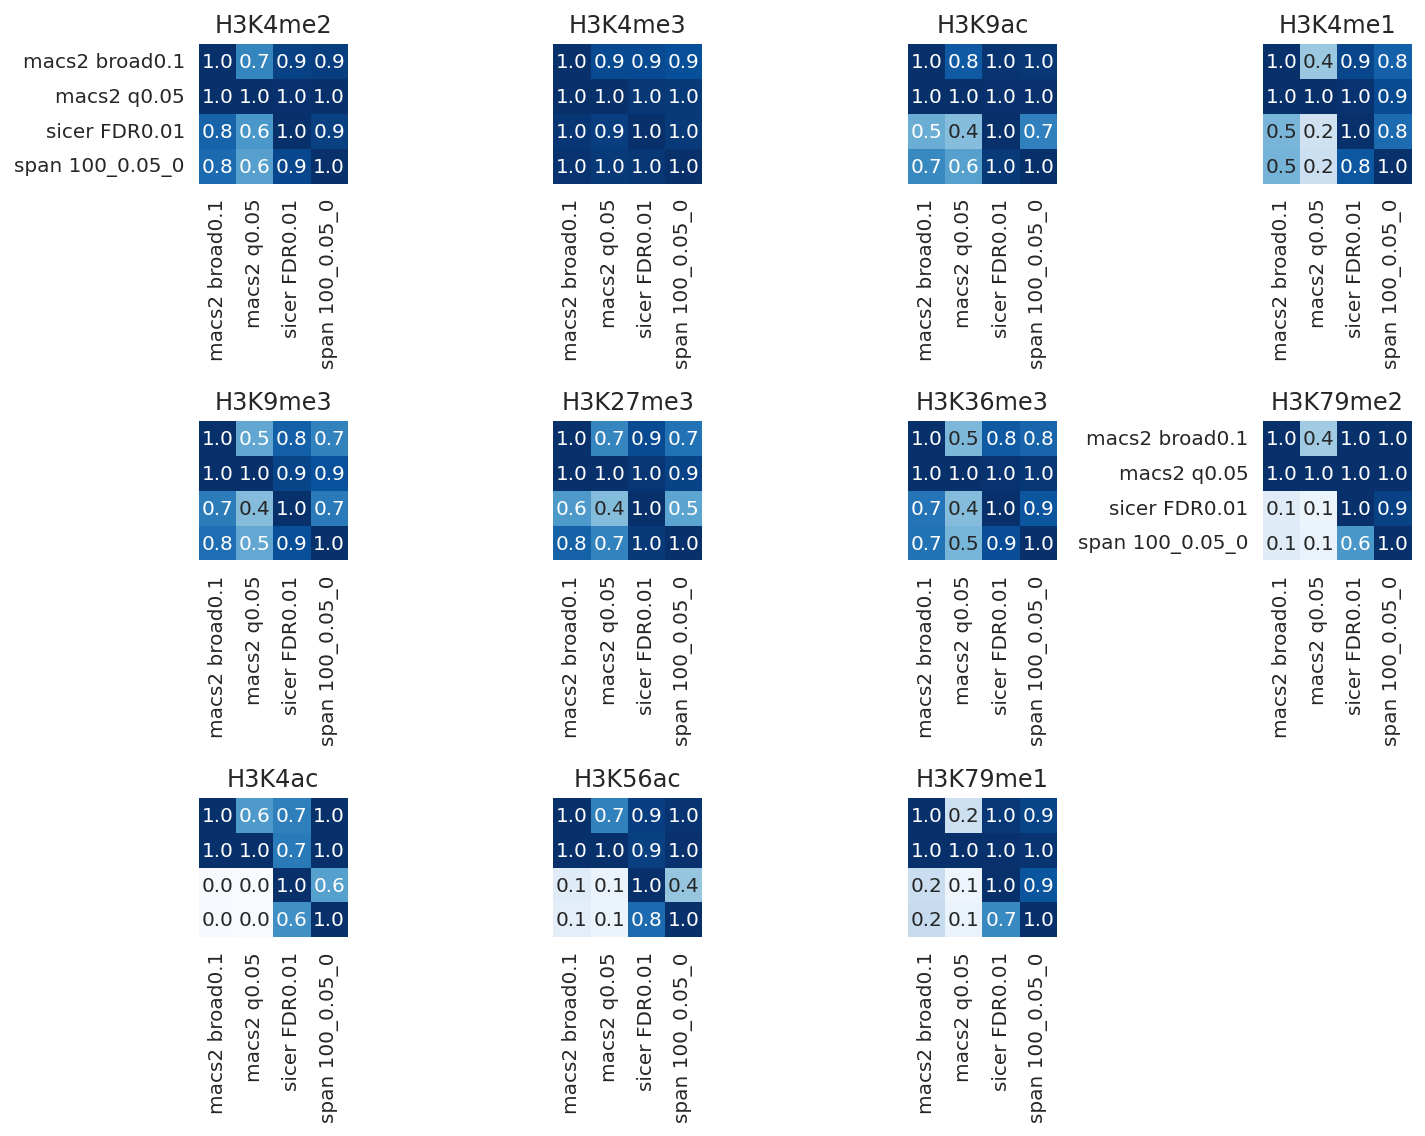

In [28]:
from math import ceil

#Heatmaps
fig = plt.figure(figsize=(10, 8))
for i, m in enumerate(MODIFICATIONS):
    print(m)
    tom = to[to['modification'] == m].groupby(['tool1', 'tool2'])['overlap'].mean().reset_index().copy()
    tomp = tom.pivot(index='tool1', columns='tool2', values='overlap').fillna(1.0)
    ax = plt.subplot(3, int(ceil(len(MODIFICATIONS) / 3)), i + 1)
    sns.heatmap(tomp, ax=ax, vmin=0, vmax=1, annot=True, fmt='.1f',
                yticklabels=(i == 0 or i == 7), cbar=False, cmap='Blues')
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title(m)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'overlap_tools.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

## Jaccard between tools

In [29]:
tj = pd.DataFrame(columns=['modification', 'replicate', 'tool1', 'tool2', 'jaccard'], dtype=object)
for _, row in tools_overlap.iterrows():
    m = row['modification']
    rep = row['rep']
    tool1 = row['tool1']
    tool2 = row['tool2']
    length1 = row['length1']
    length2 = row['length2']
    intersection = row['intersect']
    try:
        jaccard = intersection / (length1 + length2 - intersection)
    except:
        jaccard = 0
    tj.loc[len(tj)] = (m, rep, tool1, tool2, jaccard)

H3K4me2
H3K4me3
H3K9ac
H3K4me1
H3K9me3
H3K27me3
H3K36me3
H3K79me2
H3K4ac
H3K56ac
H3K79me1


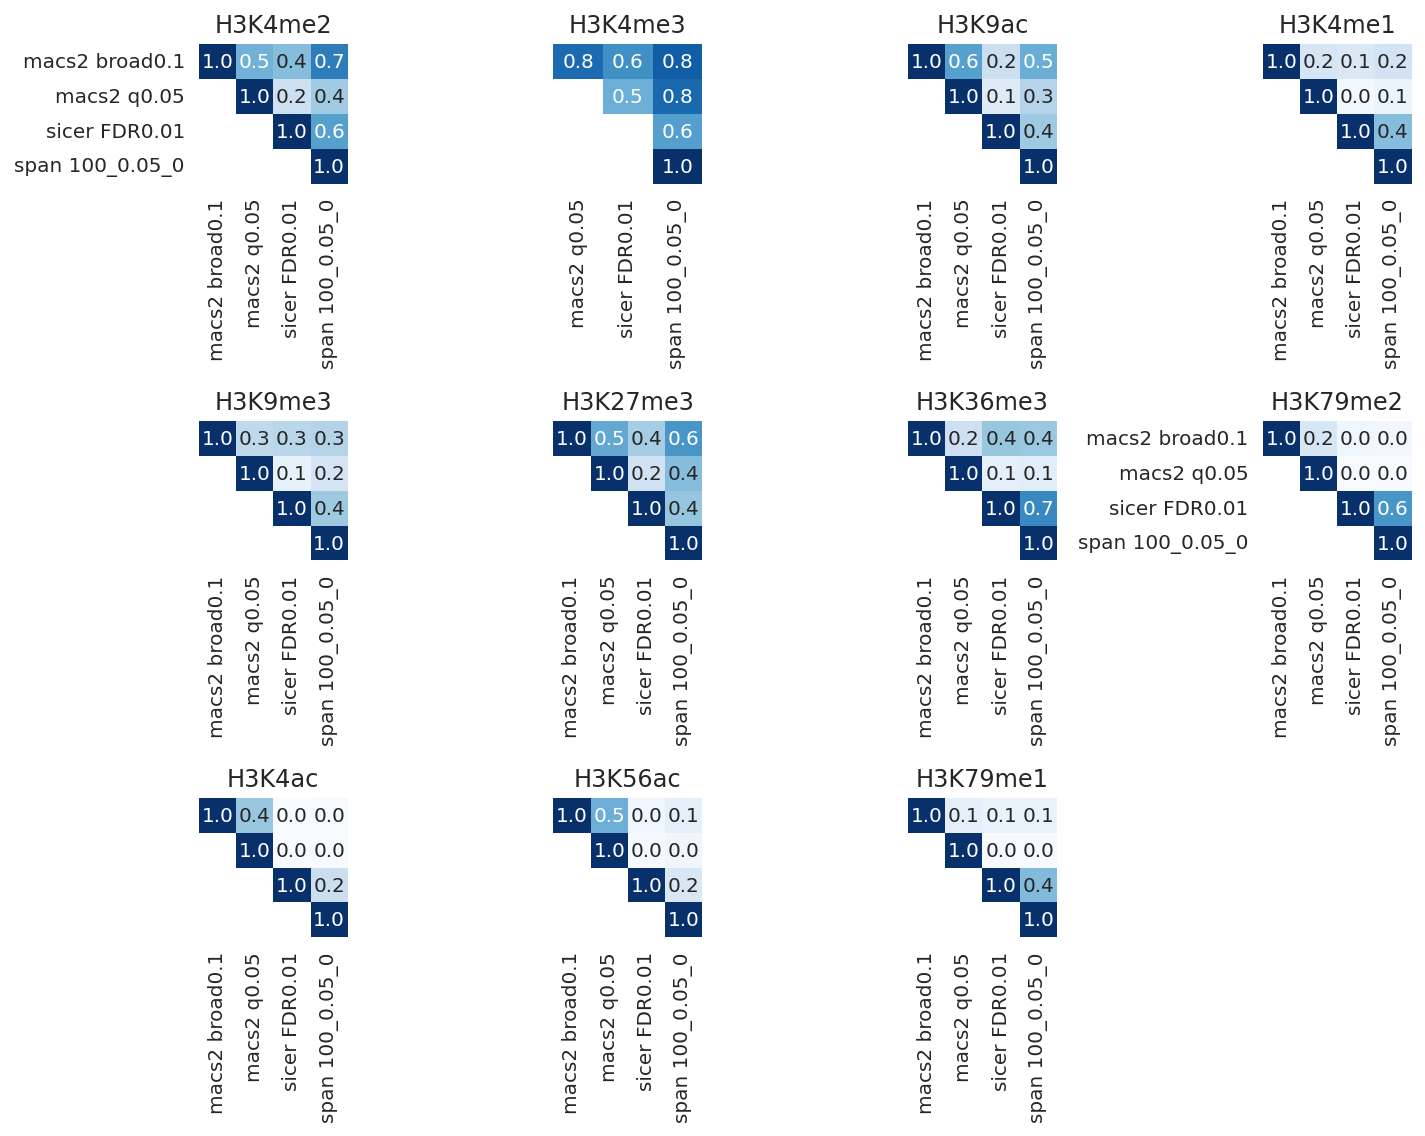

In [30]:
#Heatmaps
fig = plt.figure(figsize=(10, 8))

for i, m in enumerate(MODIFICATIONS):
    print(m)
    tjm = tj[tj['modification'] == m].copy()
    for t in tools:
        tjm.loc[len(tjm)] = (m, 'rep', t, t, 1.0)
    tjm = tjm.groupby(['tool1', 'tool2'])['jaccard'].mean().reset_index().copy()
    tjmp = tjm.pivot(index='tool1', columns='tool2', values='jaccard')
    ax = plt.subplot(3, int(ceil(len(MODIFICATIONS) / 3)), i + 1)
    sns.heatmap(tjmp, ax=ax, vmin=0, vmax=1, annot=True, fmt='.1f',
                yticklabels=(i == 0 or i == 7), cbar=False, cmap='Blues')
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title(m)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard_tools.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()